In [ ]:
#this is where I will be merging all 3 of my data sets
#I've learned all of these before, seaborn was used in INFO2201 last year during spring semester
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
#loading in the data sets
regular1 = pd.read_csv("Raw Data/regular1.csv")
regular2 = pd.read_csv("Raw Data/regular 2.csv")
regular3 = pd.read_csv("Raw Data/regular 3.csv")
totals = pd.read_csv("Raw Data/regulartotals.csv")


In [ ]:
#merging the data sets for simplicty
stats = pd.concat([regular1, regular2, regular3], ignore_index=True)

In [34]:
#renaming the columns of the next file so they can merge
stats.rename(columns={
    'SEASON_YEAR': 'season_year',
    'TEAM_ID': 'teamId',
    'GAME_ID': 'gameId'}, inplace=True)


In [42]:
#renaming the columns of the totals file so they can merge
#one file had upper case column names and the other had lower case
totals.rename(columns={
    'SEASON_YEAR': 'season_year',
    'TEAM_ID': 'teamId',
    'GAME_ID': 'gameId'
}, inplace=True)

#using pd.merge to merge the two data sets on season year, team id, and game id
winloss = pd.merge(
    stats,
    totals[['season_year', 'teamId', 'gameId', 'WL']],
    on=['season_year', 'teamId', 'gameId'],
    how='left'
)


In [ ]:

#creating a new csv so I don't lose the data
winloss.to_csv("merged_winloss_data.csv", index=False)

In [51]:
#filtering the players in the merged data set by the players involved in the trade
players = ['Kawhi Leonard', 'DeMar DeRozan']
tradedata1 = winloss[winloss['personName'].isin(players)]

In [ ]:
#this code aggregates the data by player and season, calculating total games played, total points scored, and average plus-minus points
#the total points data will be divided by the games played to get a points per game average

tradestats1 = tradedata1.groupby(['personName', 'season_year']).agg(
    games_played=('gameId', 'nunique'),
    total_points=('points', 'sum'),
    avg_plus_minus=('plusMinusPoints', 'mean')
).reset_index()


In [74]:
# creating a new points per game column calculated by total points divided by games played
tradestats1 = tradedata1.groupby(['personName', 'season_year']).agg(
    games_played=('gameId', 'nunique'),
    total_points=('points', 'sum'),
    avg_plus_minus=('plusMinusPoints', 'mean')
).reset_index()

#created a new points per game column calculated by total points divided by games played
tradestats1['ppg'] = tradestats1['total_points'] / tradestats1['games_played']
#reordering the columns for better readability
tradestats1 = tradestats1[['personName', 'season_year', 'games_played', 'ppg', 'avg_plus_minus']]

In [159]:
# CHARTS FOR THE TRADE
#gets the years that we are interested in
#finds data that contains the two players and the seasons before and after the trade (2016-17, 2017-18, 2018-19)
tradeseasons1 = ['2016-17', '2017-18', '2018-19']
filtered1 = tradestats1[
    (tradestats1['personName'].isin(['Kawhi Leonard', 'DeMar DeRozan'])) &
    (tradestats1['season_year'].isin(tradeseasons1))
]



C:\Users\crawf\AppData\Local\Temp\ipykernel_81964\3271736178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered1['trade_period'] = filtered1.apply(label_period, axis=1)
C:\Users\crawf\AppData\Local\Temp\ipykernel_81964\3271736178.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


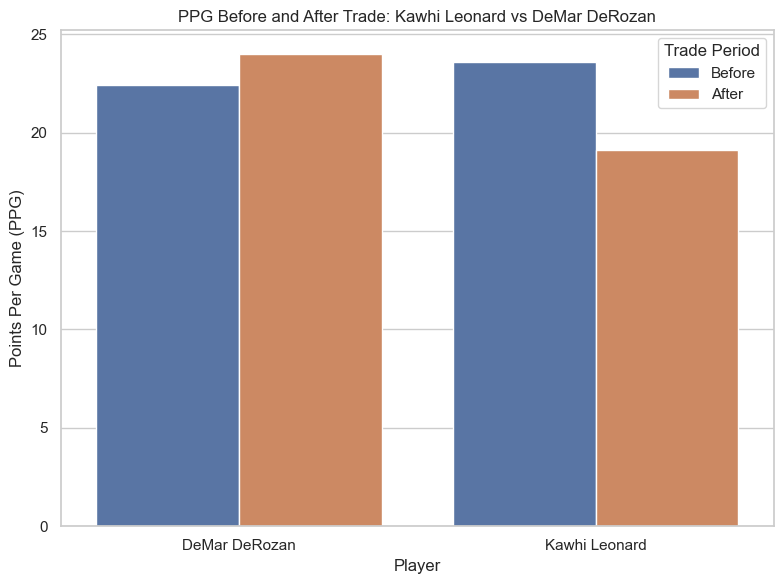

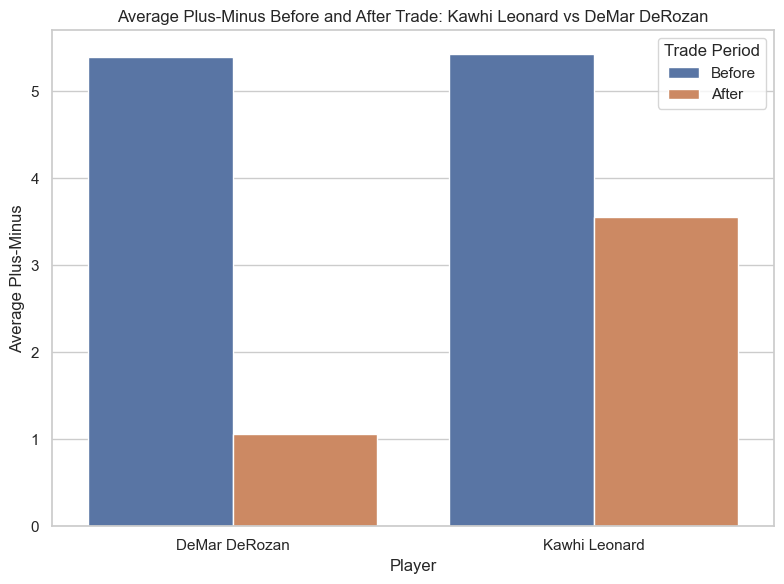

In [134]:
# Create trade_period column
def label_period(row):
    if row['personName'] == 'Kawhi Leonard':
        return 'Before' if row['season_year'] == '2016-17' else 'After'
    elif row['personName'] == 'DeMar DeRozan':
        return 'Before' if row['season_year'] == '2017-18' else 'After'

filtered1['trade_period'] = filtered1.apply(label_period, axis=1)

# bar chart for points per game before and after the trade
plt.figure(figsize=(8, 6))
sns.barplot(
    data=filtered1,
    x='personName',
    y='ppg',
    hue='trade_period',
    hue_order=['Before', 'After'],
    ci=None
)

plt.title('PPG Before and After Trade: Kawhi Leonard vs DeMar DeRozan')
plt.xlabel('Player')
plt.ylabel('Points Per Game (PPG)')
plt.legend(title='Trade Period')
plt.tight_layout()
plt.show()


# Bar chart for average plus-minus before and after the trade
plt.figure(figsize=(8, 6))
sns.barplot(
    data=filtered1,
    x='personName',
    y='avg_plus_minus',
    hue='trade_period',
    hue_order=['Before', 'After'],
    errorbar=None
)

plt.title('Average Plus-Minus Before and After Trade: Kawhi Leonard vs DeMar DeRozan')
plt.xlabel('Player')
plt.ylabel('Average Plus-Minus')
plt.legend(title='Trade Period')
plt.tight_layout()
plt.show()




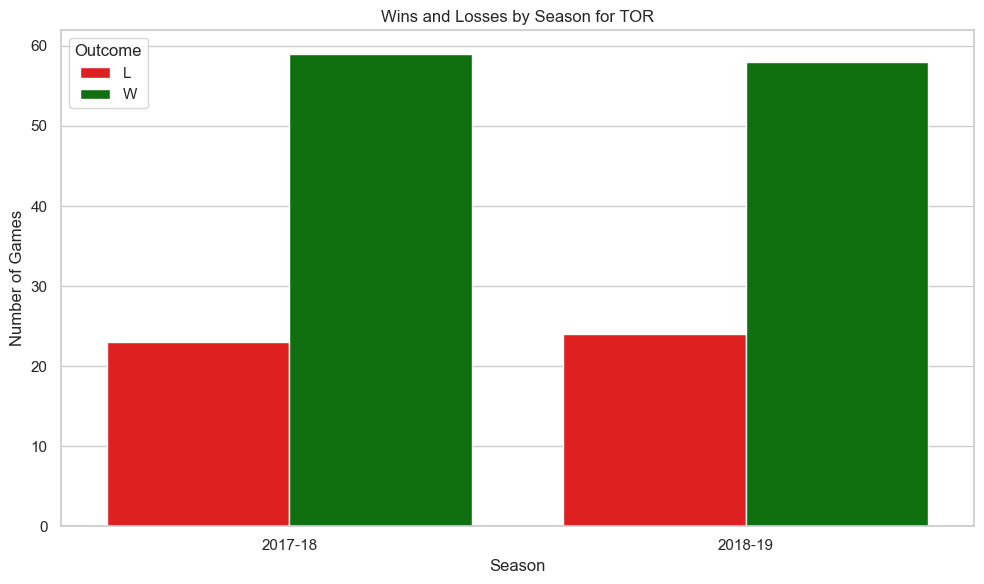

In [211]:
# Extend seasons to 3 before and 3 after the trade (assuming trade in 2017-18)
tradeseasons_extended = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
tradeteams1 = ['TOR']  # or ['TOR', 'SAS'] if you want both

filtered_wl_unique = (
    filtered_wl[
        (filtered_wl['teamTricode'].isin(tradeteams1)) &
        (filtered_wl['season_year'].isin(tradeseasons_extended))
    ]
    .drop_duplicates(subset=['teamTricode', 'season_year', 'gameId'])
)

team_wl_summary = (
    filtered_wl_unique
    .groupby(['teamTricode', 'season_year', 'WL'])
    .size()
    .reset_index(name='count')
)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=team_wl_summary,
    x='season_year',
    y='count',
    hue='WL',
    palette={'W': 'green', 'L': 'red'},
    errorbar=None
)
plt.title(f'Wins and Losses by Season for {", ".join(tradeteams1)}')
plt.xlabel('Season')
plt.ylabel('Number of Games')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()


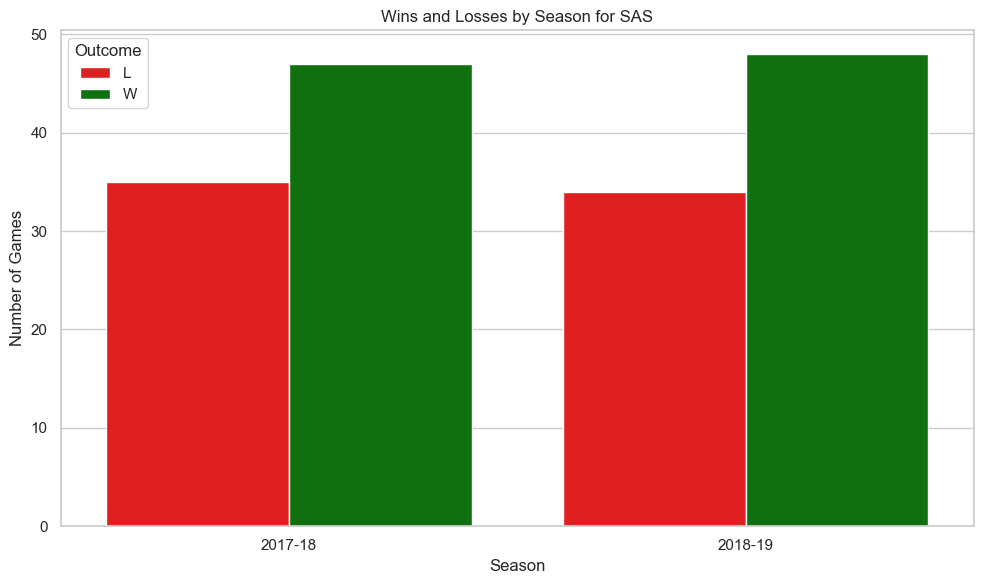

In [212]:
# Extend seasons to 3 before and 3 after the trade (assuming trade in 2017-18)
tradeseasons_extended = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
tradeteams1 = ['SAS']  # or ['TOR', 'SAS'] if you want both

filtered_wl_unique = (
    filtered_wl[
        (filtered_wl['teamTricode'].isin(tradeteams1)) &
        (filtered_wl['season_year'].isin(tradeseasons_extended))
    ]
    .drop_duplicates(subset=['teamTricode', 'season_year', 'gameId'])
)

team_wl_summary = (
    filtered_wl_unique
    .groupby(['teamTricode', 'season_year', 'WL'])
    .size()
    .reset_index(name='count')
)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=team_wl_summary,
    x='season_year',
    y='count',
    hue='WL',
    palette={'W': 'green', 'L': 'red'},
    errorbar=None
)
plt.title(f'Wins and Losses by Season for {", ".join(tradeteams1)}')
plt.xlabel('Season')
plt.ylabel('Number of Games')
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()


